In [1]:
# here we're going to just try writing something from scratch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# set up arrays
dx = 1000
x = np.arange(0, 100000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [4]:
# set up parameters
# K_ig = np.zeros(len(x))
# K_ig[:24] = 1e-7
# K_sed = np.zeros(len(x))
# K_sed[24:] = 1e-6
K = np.zeros(len(x))
K[:] = 1e-7

# beta_ig = np.zeros(len(x))
# beta_ig[:24] = 4e-7
# beta_sed = np.zeros(len(x))
# beta_sed[24:] = 4e-6
beta = np.zeros(len(x))
beta[:] = 3e-4

# psi = np.zeros(len(x))
# psi[:14] = 4e-7
# psi[14:] = 4e-6
psi = 3e-4
gamma = 0.3

r = 10. # runoff rate
D = 0.03 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [5]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.
# Pxb = 1
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [6]:
len(eta)

100

In [7]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K[1:] * Q[1:] * S * alpha[:-1]
        Eb_a[:-1] = beta[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        ql[1:] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:])))
        # ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta)

In [8]:
#now write a test
num_steps = 1500000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

7500000.0


In [9]:
dt

5

In [10]:
E

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04])

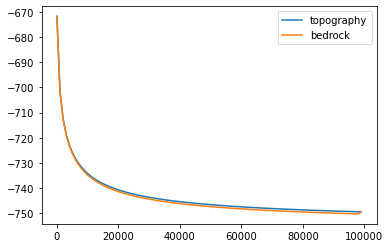

In [11]:
plt.plot(x, eta, label = "topography")
plt.plot(x, etab, label = "bedrock")
# plt.plot(x, H, label = "sediment")
plt.legend()

In [12]:
Q

array([0.00000000e+00, 3.33333333e+06, 1.33333333e+07, 3.00000000e+07,
       5.33333333e+07, 8.33333333e+07, 1.20000000e+08, 1.63333333e+08,
       2.13333333e+08, 2.70000000e+08, 3.33333333e+08, 4.03333333e+08,
       4.80000000e+08, 5.63333333e+08, 6.53333333e+08, 7.50000000e+08,
       8.53333333e+08, 9.63333333e+08, 1.08000000e+09, 1.20333333e+09,
       1.33333333e+09, 1.47000000e+09, 1.61333333e+09, 1.76333333e+09,
       1.92000000e+09, 2.08333333e+09, 2.25333333e+09, 2.43000000e+09,
       2.61333333e+09, 2.80333333e+09, 3.00000000e+09, 3.20333333e+09,
       3.41333333e+09, 3.63000000e+09, 3.85333333e+09, 4.08333333e+09,
       4.32000000e+09, 4.56333333e+09, 4.81333333e+09, 5.07000000e+09,
       5.33333333e+09, 5.60333333e+09, 5.88000000e+09, 6.16333333e+09,
       6.45333333e+09, 6.75000000e+09, 7.05333333e+09, 7.36333333e+09,
       7.68000000e+09, 8.00333333e+09, 8.33333333e+09, 8.67000000e+09,
       9.01333333e+09, 9.36333333e+09, 9.72000000e+09, 1.00833333e+10,
      

In [13]:
# just for kicks
kb = 8.3e-8
b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
print(b)

[0.87806251 1.09374307 1.26942578 1.42282008 1.55591381 1.67115103
 1.77112832 1.85825494 1.93463382 2.00204626 2.0619772  2.11565381
 2.16408549 2.20810077 2.24837942 2.28547964 2.31986061 2.35190099
 2.38191404 2.41015984 2.43685526 2.46218191 2.48629262 2.5093167
 2.53136407 2.55252873 2.5728915  2.59252223 2.61148166 2.62982287
 2.64759252 2.66483181 2.68157732 2.69786171 2.7137142  2.72916113
 2.7442263  2.7589313  2.77329578 2.78733772 2.80107358 2.81451853
 2.82768652 2.84059047 2.85324234 2.86565326 2.87783358 2.88979296
 2.90154041 2.9130844  2.92443285 2.93559321 2.94657248 2.95737727
 2.9680138  2.97848795 2.98880529 2.9989711  3.00899035 3.01886781
 3.02860796 3.03821509 3.04769328 3.0570464  3.06627817 3.07539211
 3.0843916  3.09327986 3.10205998 3.11073491 3.11930747 3.12778038
 3.13615623 3.14443753 3.15262665 3.16072592 3.16873754 3.17666363
 3.18450626 3.19226738 3.19994891 3.20755267 3.21508044 3.22253391
 3.22991473 3.2372245  3.24446475 3.25163696 3.25874257 3.26578

In [14]:
# ok really going out on a limb here...
depth = (0.09801 * D) / S
print(depth)

[ 0.09918881  0.26961952  0.47552327  0.70613432  0.95880691  1.23274472
  1.5276      1.84309819  2.17893412  2.53475056  2.910143    3.30467204
  3.71787683  4.14928701  4.59843255  5.06485129  5.5480945   6.04773066
  6.56334784  7.09455498  7.64098234  8.20228125  8.77812355  9.36820062
  9.97222235 10.5899159  11.22102452 11.86530633 12.52253319 13.19248955
 13.8749715  14.56978576 15.27674885 15.99568627 16.7264318  17.46882686
 18.22271988 18.9879658  19.76442561 20.55196585 21.35045831 22.15977957
 22.9798108  23.81043736 24.6515486  25.50303761 26.36480097 27.23673861
 28.11875355 29.0107518  29.91264214 30.82433605 31.74574749 32.67679285
 33.61739082 34.56746224 35.52693005 36.49571917 37.47375643 38.46097047
 39.45729168 40.46265213 41.47698547 42.50022692 43.53231314 44.57318226
 45.62277375 46.68102839 47.74788827 48.82329665 49.90719803 50.999538
 52.10026328 53.20932164 54.32666188 55.45223381 56.58598818 57.72787667
 58.87785189 60.03586728 61.20187717 62.37583669 63.5

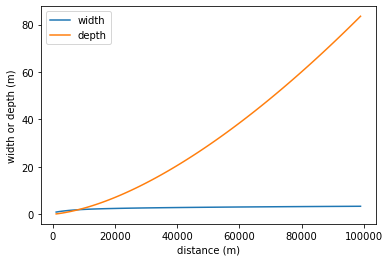

In [15]:
plt.plot(x[1:], b, label = 'width')
plt.plot(x[1:], depth, label = 'depth')
plt.ylabel('width or depth (m)')
plt.xlabel('distance (m)')
plt.legend()

(0.0, 1.0)

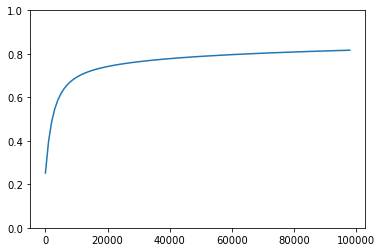

In [16]:
plt.plot(x[:-1], 1-alpha[:-1])
plt.ylim(0, 1.0)

In [17]:
type(alpha)

numpy.ndarray

In [18]:
from numpy import savetxt

In [19]:
savetxt('alpha run 14.csv', alpha, delimiter = ',')

In [20]:
savetxt('slope run 14.csv', S, delimiter = ',')

In [21]:
savetxt('topo run 14.csv', eta, delimiter = ',')
savetxt('bedrock run 14.csv', etab, delimiter = ',')